#Automating Binwidth for pyplot.hist

When using pyplot.hist, the main problem I face is the fact that the number of bins is not dynamic. So whether I have a 50 samples or 5 million samples, by default I have 10 bins. I have to experiment until I get something I like, I don't even get a half decent choice, like in R, nor are different methods avaiable for automatically choosing the binwidths.

For example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot') #this should be in the matplotlib.__init__.py
%load_ext rpy2.ipython

In [2]:
def gen3peaks(numPoints):
    numPoints/=3
    x1 = np.random.randn(numPoints) * 15 + 100
    x2 = np.random.randn(numPoints) * 10 + 60
    x3 = np.random.randn(numPoints) * 5+ 140
    return np.hstack((x1,x2, x3))

xbig = gen3peaks(30000)
xsmall = gen3peaks(150)

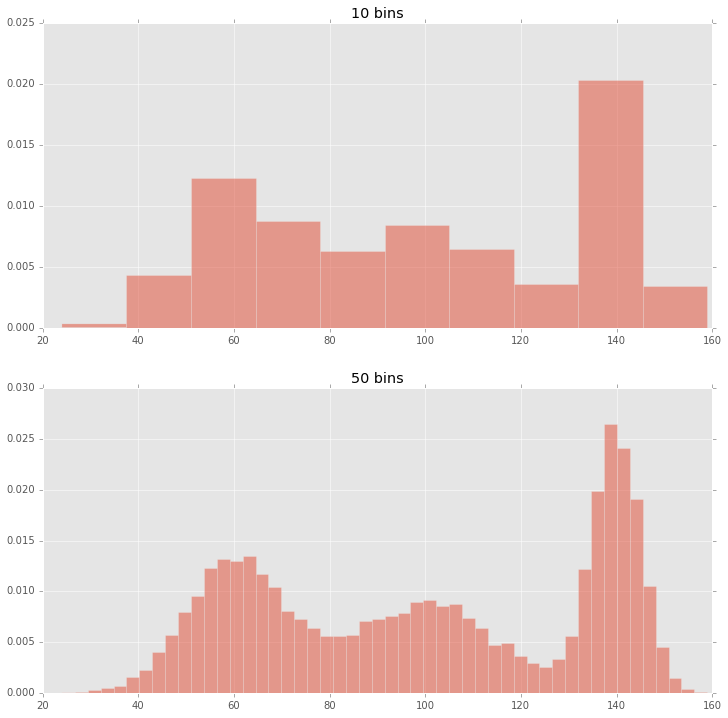

In [3]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.hist(xbig, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(212)
plt.hist(xbig, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")

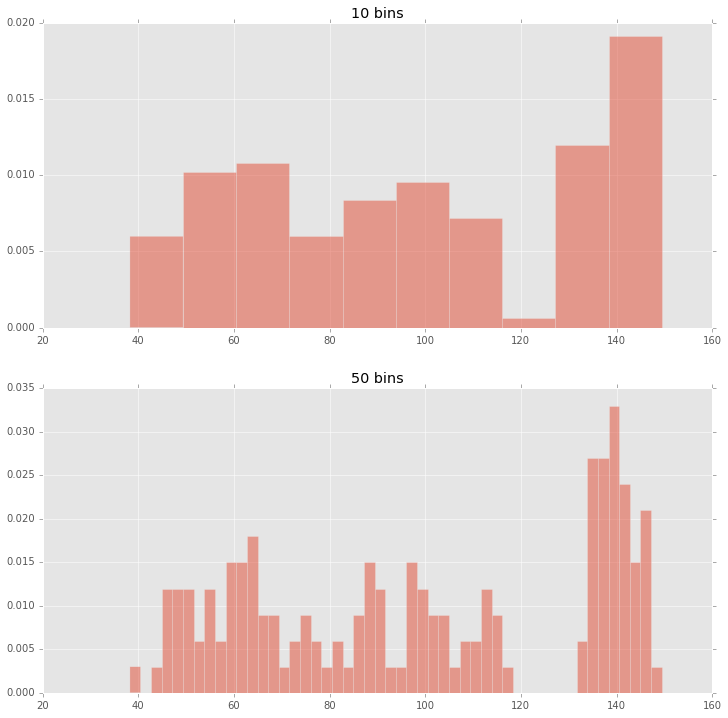

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.hist(xsmall, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(212)
plt.hist(xsmall, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")

In [4]:
%R -i xbig,xsmall

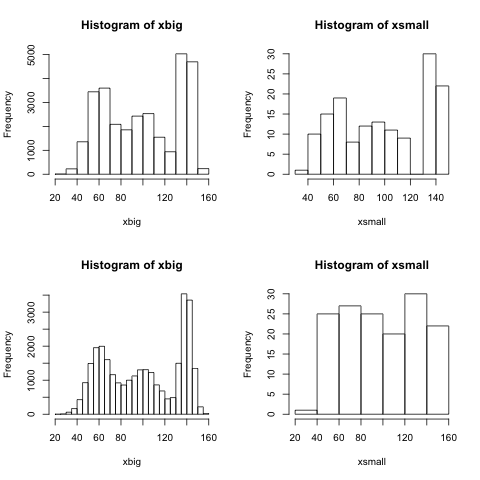

In [12]:
%%R
# par(fin = c(12,12))  # doesn't work well in ipython
par(mfrow=c(2,2))
hist(xbig);
hist(xsmall);
#second row is scott
hist(xbig, 'scott');
hist(xsmall, 'scott');

It is obvious that R is clearly adapting to the amount and the type of data being passed in (even giving options for the automatic bin selection). It should be noted that R has a `pretty` method that interferes a little bit, making the sections start on whole numbers, with preference given to multiples of 2 and 5 and some freedom to increase or decrease the number of bins. Either way, the hist method that R provides gives us better functionality out of the box.

#Solution

Provide some kind of similar functionality for hist, taking inspiration from R's methods. Pretty can be implemented at a later stage if necessary. The focus here is to provide at least some kind of adaptability for the hist method.

* n = size of data
* h = binwidth
* Number of bins $\propto 1/h$
* The $\left\lceil f(x) \right\rceil$ mean the ceiling of the function

We implement 5 methods here:

1. Sturges - default method in R
    * Number of Bins = $\left\lceil \log _{2}n+1 \right\rceil$
2. Rice - Sturges alternative
    * Number of Bins = $\left\lceil 2n^{-1/3} \right\rceil$
3. Sturges Rice Average
    * Number of Bins = average(Sturges, Rice)
4. Scott - provided method in R
    * Binwidth = $\frac{3.5\sigma}{n^{-1/3}}$ 
    * if the binwidth is estimated to be 0, then return 1 as the number of bins
5. Freeman Diaconis - provided method in R
    * Binwidth = $2 \frac{IQR}{n^{-1/3}}$ 
    * If IQR is 0, then use the Median Absolute Deviation instead as IQR. If it too is 0, return 1

It is a known fact that the asymptotically optimal number of bins is proportional to $n^{1/3}$, which is the motivating reason behind the $n^{1/3}$ in the expressions above (binwidth ~ $n^{-1/3}$). This project been motivated by my study of non-parametrics at university.

## Further Reading/ Resources
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/grDevices/html/nclass.html) on the included methods for automatic bin numbers. Note, that opening up an R console and typing nclass.Sturges (or scott, FD) will output the code. The publication references are provided.
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/graphics/html/hist.html) on histograms
* [Wikipedia](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) for an overview of the methods and a simple argument for the optimality of $n^{1/3}$ for number of bins

In [21]:
def min6decorator(func):
    """"
    Decorate the estimators in case we need to provide a lower bound
    """
    def inner(*args, **kwargs):
        return max(func(*args, **kwargs), 6)
    return inner

def sturges(x):
    """
    Using Sturges estimator
    Very simplistic based on logarithms, however 
    poorer performance for large datasets and non-normal data
    """
    return np.ceil(np.log2(x.size)) + 1

def rice(x):
    """
    A similar version of sturges with another simple estimator. Better performance for larger datasets
    The number of bins is proportional to the cube root of data size
    """
    return np.ceil(2 * len(x) ** (1.0/3))


def SturgesRice(x):
    """
    An average or the Rice and Sturges - works surprisingly well in practice
    """
    return np.ceil((rice(x) + sturges(x))/2)

def scott(x):
    """
    The binwidth is proprtional to the standard deviation of the data and 
    inversely proportional to the cube root of data size
  
    """
    h = 3.5 * x.std() * x.size **(-1.0/3)
    if h>0:
        return np.ceil(x.ptp()/h)
    return 1

def mad(data, axis=None):
    """
    Mean Absolute Deviation - simple function
    """
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def FD(x):
    """
    Freeman Diaconis rule using IQR for binwidth
    Considered a variation of the Scott rule with more robustness as the Inter quartile range
    is less affected by outliers than the standard deviation.
    
    If the IQR is 0, we return the median absolute deviation as defined above, else 1
    """
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    
    if iqr ==0: #unlikely
        iqr = mad(x) # replace with something useful
    
    h = (2 * iqr * x.size**(-1.0/3)) # binwidth
    
    if iqr > 0:
        return np.ceil(x.ptp()/h)

    return 1 #all else fails
                       
autoMethods = [sturges, rice, SturgesRice, scott, FD]

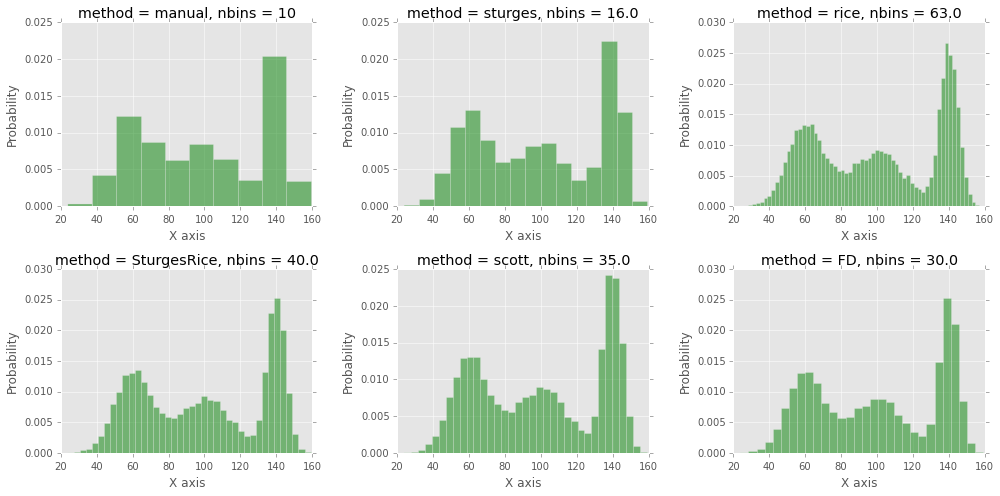

In [24]:
def methodDisplay(x, manual = 10):

    num_bins = [manual] + map(lambda method: method(x), autoMethods)
    bindesc = ["manual"] + map(lambda method: method.__name__, autoMethods)

    plt.figure(tight_layout=True, figsize=(14,7))


    for i in range(len(bindesc)):
        binChoice = num_bins[i]
        desc = bindesc[i]
        plt.subplot(2,3,i+1)
        # the histogram of the data
        n, bins, patches = plt.hist(x, binChoice, normed=1, facecolor = 'green', alpha=0.5)
        plt.xlabel('X axis')
        plt.ylabel('Probability')
        plt.title(r'method = {1}, nbins = {0}'.format(binChoice, desc))

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
    plt.show()
                  
methodDisplay(xbig)

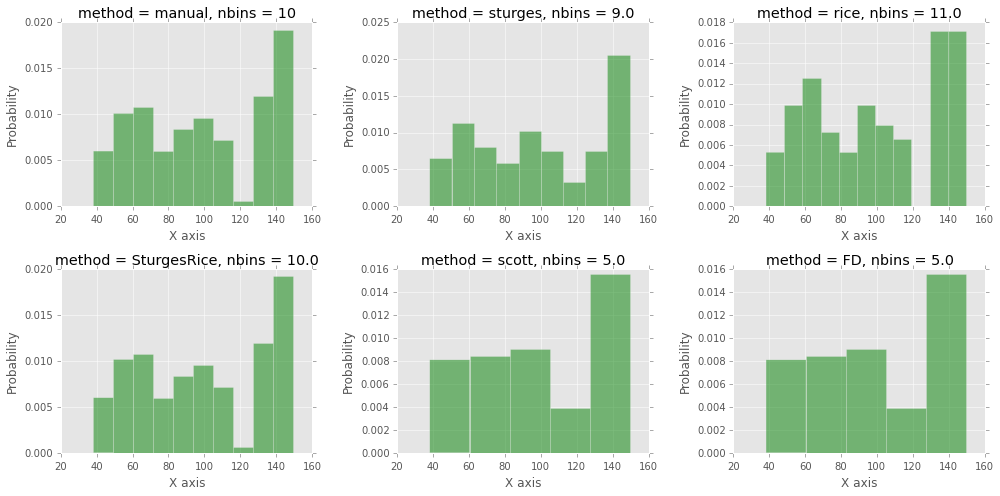

In [25]:
methodDisplay(xsmall)